# ECE 219 Project 3: Recommender Systems

In [1]:
# import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# allows matlab plots to be generated in line
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive/")

# add system path to current directory
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECE_219/Project3')

Mounted at /content/drive/


## 4. Dataset

In [2]:
# read all csv files
path = '/content/drive/MyDrive/Colab Notebooks/ECE_219/Project3/dataset'
ratings_df = pd.read_csv(f'{path}/ratings.csv', index_col=0)
links_df = pd.read_csv(f'{path}/links.csv')
movies_df = pd.read_csv(f'{path}/movies.csv')
tags_df = pd.read_csv(f'{path}/tags.csv')

#### Compute the sparsity of the movie rating dataset

In [3]:
movieIDs, movie_counts = np.unique(ratings_df['movieId'].to_numpy(), 
                                   return_counts=True)
num_movieID = len(movieIDs)
userIDs, user_counts = np.unique(ratings_df['userId'].to_numpy(), 
                                   return_counts=True)
num_userID = len(userIDs)

# calculate the sparsity
sparsity = ratings_df['rating'].shape[0] / (num_userID*num_movieID)
print('The sparsity of the movie rating dataset is {}'.format(sparsity))

The sparsity of the movie rating dataset is 0.016999683055613623


#### Plot a histogram showing the frequency of the rating values

<AxesSubplot:>

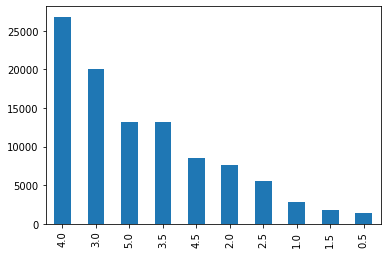

In [6]:
ratings_df['rating'].value_counts().plot(kind='bar')

#### Plot the distribution of the number of ratings received among movies

In [ ]:
# ratings_df['movieId'].value_counts().plot(kind='bar')

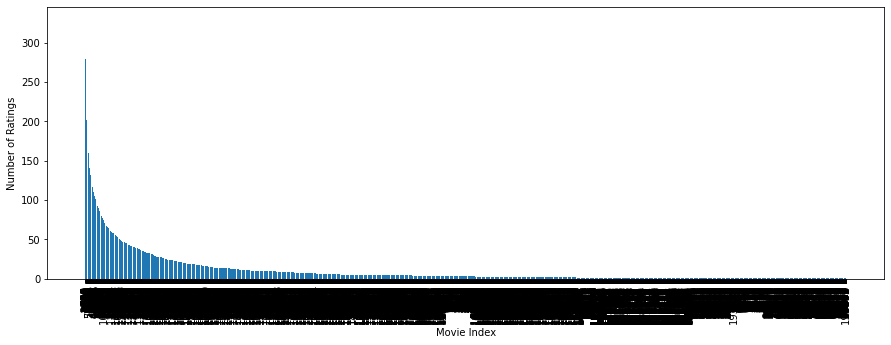

In [7]:
unique, counts = np.unique(ratings_df['movieId'].to_numpy(), return_counts=True)

sorted_counts = counts[np.argsort(-counts)]
sorted_unique = unique[np.argsort(-counts)]

# plot
plt.figure(figsize=(15, 5))
plt.bar(range(len(sorted_unique)), sorted_counts)
plt.xticks(range(len(sorted_unique)), sorted_unique, rotation=90)
plt.xlabel("Movie Index")
plt.ylabel("Number of Ratings")
plt.show()

#### Plot the distribution of ratings among users

In [ ]:
# ratings_df['userId'].value_counts().plot(kind='bar')

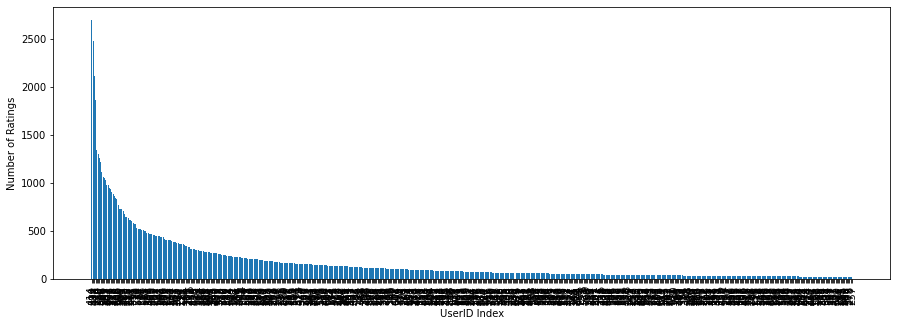

In [9]:
unique, counts = np.unique(ratings_df['userId'].to_numpy(), return_counts=True)

sorted_counts = counts[np.argsort(-counts)]
sorted_unique = unique[np.argsort(-counts)]

# plot
plt.figure(figsize=(15, 5))
plt.bar(range(len(sorted_unique)), sorted_counts)
plt.xticks(range(len(sorted_unique)), sorted_unique, rotation=90)
plt.xlabel("UserID Index")
plt.ylabel("Number of Ratings")
plt.show()

#### Compute the variance of the rating values received by each movie

<AxesSubplot:>

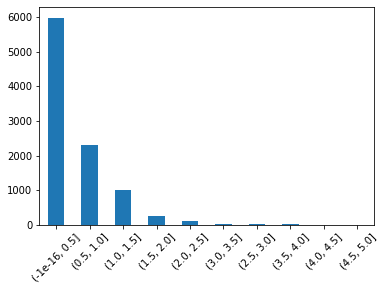

In [27]:
# init
vars = []

# get all unique movie IDs
movieIDs, movie_counts = np.unique(ratings_df['movieId'].to_numpy(), return_counts=True)

# start looping and calculating variance
for i in range(len(movieIDs)):
    idx = np.where(ratings_df['movieId'] == movieIDs[i])[0]
    rates = ratings_df['rating'].to_numpy()[idx]
    # double check the number of rates matches the number of movie_counts
    assert len(rates) == movie_counts[i]
    vars.append(np.var(rates))

# create dataframe
vars_df = pd.DataFrame(np.array(vars), columns = ['variance'])
vars_df['var_group'] = pd.cut(vars_df['variance'], bins=list(np.arange(-1e-16, 5.5, 0.5)))

vars_df['var_group'].value_counts().plot(kind='bar', rot=45)

<div class="alert alert-block alert-success">
<b>QUESTION 1:</b> Explore the Dataset: In this question, we explore the structure of the data.
<ul>
  <li><b>A) Compute the sparsity of the movie rating dataset.</b></li>
  <li><b>B) Plot a histogram showing the frequency of the rating values.</b></li>
  <li><b>C) Plot the distribution of the number of ratings received among movies.</b></li>
  <li><b>D) Plot the distribution of ratings among users</b></li>
  <li><b>E) Discuss the salient features of the distributions</b></li>
  <li><b>F) Compute the variance of the rating values received by each movie</b></li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 1:</b>
<ul>
  <li><b>A) </b>The sparsity of the movie rating dataset is around 0.017</li>
  <li><b>B) </b>as shown above</li>
  <li><b>C) </b>as shown above</li>
  <li><b>D) </b>as shown above</li>
  <li><b>E) </b>From plot C, we can observe that there is a large imbalance distribution in number of rating among different movie IDs. Most of the movies have only been rated under 25 times, whereas a small portion of popular movie got rated over 25 times or even more like 50, 100 times. Similarly, in plot D, the imbalance distribution are shown, meaning that the number that each users rated different movies differ greatly. Most of the users only rated under 50 movies and some users rated over 500 movies. This imbalance distribution in the dataset implies for the recommendation process that we have to take the imbalance into condiseration and find a way to tackle it, otherwise this recommendation system will lead toward certain people's preference.</li>
  <li><b>F) </b>The plot is shown above. Based on the shape as well as the distribution of the resulting histogram, one can conclude that most of the movies receive similar rate from different users. That's why most the movie rates have low variance.</li>
</ul>
</div>

## 5. Neighborhood-based collaborative filtering

### 5.2 Pearson-correlation coefficient

The Pearson-correlation coefficient between users $u$ and $v$ denoted by $Pearson(u,v)$ captures the similarity between the rating vectors of users $u$ and $v$. First some notation:
<ul>
  <li>$I_u$: Set of item indices for which ratings have been specified by user $u$</li>
  <li>$I_v$: Set of item indices for which ratings have been specified by user $v$</li>
  <li>$\mu_u$: Mean rating for user $u$ computed using her specified ratings</li>
  <li>$r_{uk}$: Rating of user $u$ for item $k$</li>
</ul>

<div class="alert alert-block alert-success">
<b>QUESTION 2:</b> Understanding the Pearson Correlation Coefficient:
<ul>
  <li>A) Write down the formula for $\mu_u$ in terms of $I_u$ and $r_{uk}$</li>
  <li>B) In plain words, explain the meaning of $I_u \cap I_v$. Can $I_u \cap I_v = \emptyset$ ? (Hint: Rating matrix $R$ is sparse)</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 2:</b> Understanding the Pearson Correlation Coefficient:
<ul>
  <li>A) $\mu_u =  \frac{1}{total\_number(I_u)} \Sigma_{k \in I_u} r_{uk}$</li>
  <li>B) $I_u \cap I_v$ means a set of item indices for which ratings have been specified by both user $u$ and $v$. It can also be an empty set $\emptyset$, meaning that the user $u$ and $v$ haven't rated any same movie.</li>
</ul>
</div>

### 5.4 Prediction function

<div class="alert alert-block alert-success">
<b>QUESTION 3:</b> Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings $(r_{vj} − \mu_v)$ in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 3:</b> Since each user $v$ has their own standard and preference of rating higher or lower for each items, we have to take it into consideration and avoiding it in prediction. That's why the mean-centering the raw ratings $(r_{vj} − \mu_v)$ is utilized in the prediction function. Moreover, to make this prediction more similar to the way the user $u$ will rate, his or her own preference of rating ($\mu_u$) is added in the prediction function.
</div>

### 5.5 k-NN collaborative filter

#### 5.5.1 Design and test via cross-validation

In [29]:
# !pip install scikit-surprise

In [30]:
from surprise import Reader, Dataset, KNNWithMeans, accuracy
from surprise.model_selection import KFold, cross_validate

In [32]:
# init
rmse_list = []
mae_list = []
num_folds = 10
ks = np.arange(2, 101, 2)

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]
data = Dataset.load_from_df(df, reader)

# start sweeping k
for k in ks:
    # get the KNN model
    sim= {"name": "pearson_baseline", 
          "user_based": True, 
          "shrinkage": 0}  # 'min_support'
    knn = KNNWithMeans(k=k, sim_options=sim, verbose=False)

    # K-fold cross validation
    cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    scores = cross_validate(knn, data, measures=['rmse', 'mae'], cv=cv)

    # compute the average RMSE and average MAE
    rmse_list.append(scores['test_rmse'].mean())
    mae_list.append(scores['test_mae'].mean())

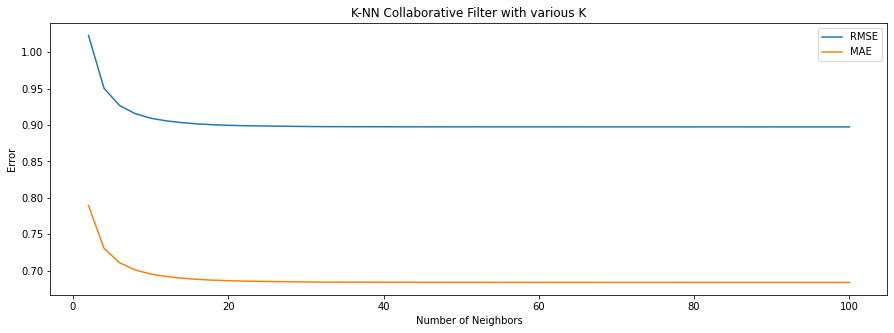

In [33]:
# plot
plt.figure(figsize=(15, 5))
plt.plot(ks, rmse_list, label='RMSE')
plt.plot(ks, mae_list, label='MAE')
plt.title('K-NN Collaborative Filter with various K')
plt.xlabel("Number of Neighbors")
plt.ylabel("Error")
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 4:</b> Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 4:</b> The results are shown above.
</div>

In [38]:
# calculate the difference and filter with threshold to find min k
threshold = 0.001
diff = (np.array(rmse_list[:-1]) - np.array(rmse_list[1:]))
first_idx = np.where(diff < threshold)[0][0]

print('The minimum k is: {}'.format(ks[first_idx]))
print('The corresponding RMSE is: {}'.format(rmse_list[first_idx]))
print('The corresponding MAE is: {}'.format(mae_list[first_idx]))

The minimum k is: 18
The corresponding RMSE is: 0.9003136164180084
The corresponding MAE is: 0.6868048484464636


<div class="alert alert-block alert-success">
<b>QUESTION 5:</b> Use the plot from question 4, to find a "minimum k". Note: The term "minimum k" in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then "minimum k" would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 5:</b> The minimum k is 18 and the corresponding RMSE is around 0.9003 and MAE is 0.6868.
</div>

#### 5.6.1 Performance evaluation using ROC curve

In [39]:
from surprise import Reader, Dataset, KNNWithMeans, accuracy
from surprise.model_selection import KFold

##### create all trimming functions 

In [40]:
def popular_trimming(df, threshold):
    '''
    Input:
        df: dataset in panda dataframe
        threshold: int value for filtering the number of ratings
    Return:
        df_trim: trimmed dataset in panda dataframe
    '''
    # get all movie IDs and each rating counts
    movieIDs, movie_counts = np.unique(df['movieId'].to_numpy(), return_counts=True)
    # filter movie IDs
    filtered_IDs = movieIDs[np.where(movie_counts > threshold)]
    # filter the dataset
    df_trim = df.loc[df['movieId'].isin(filtered_IDs)]

    return df_trim


def unpopular_trimming(df, threshold):
    '''
    Input:
        df: dataset in panda dataframe
        threshold: int value for filtering the number of ratings
    Return:
        df_trim: trimmed dataset in panda dataframe
    '''
    # get all movie IDs and each rating counts
    movieIDs, movie_counts = np.unique(df['movieId'].to_numpy(), return_counts=True)
    # filter movie IDs
    filtered_IDs = movieIDs[np.where(movie_counts <= threshold)]
    # filter the dataset
    df_trim = df.loc[df['movieId'].isin(filtered_IDs)]

    return df_trim


def high_var_trimming(df, var_thr, rate_thr):
    '''
    Input:
        df: dataset in panda dataframe
        var_thr: float value for filtering the variance
        rate_thr: int value for filtering the number of ratings
    Return:
        df_trim: trimmed dataset in panda dataframe
    '''
    # init
    vars = []

    # get all unique movie IDs
    movieIDs, movie_counts = np.unique(df['movieId'].to_numpy(), return_counts=True)

    # start looping and calculating variance
    for i in range(len(movieIDs)):
        idx = np.where(df['movieId'] == movieIDs[i])[0]
        rates = df['rating'].to_numpy()[idx]
        # double check the number of rates matches the number of movie_counts
        assert len(rates) == movie_counts[i]
        vars.append(np.var(rates))
    
    # filters (storing indices of satisfied case)
    vars_filter = np.where(np.array(vars) >= var_thr)[0]
    rate_filter = np.where(movie_counts >= rate_thr)[0]
    # filter movie IDs
    filtered_IDs = movieIDs[np.intersect1d(vars_filter, rate_filter)]
    # filter the dataset
    df_trim = df.loc[df['movieId'].isin(filtered_IDs)]

    return df_trim


##### define a function for automation of K-NN collaborative filtering with trimming

In [41]:
def knn_collab_filter(dataframe, trimming):
    '''
    Input:
        dataframe: panda dataframe of original file
        trimming: trimming technique to use - popular, unpopular, high_var, None
    Return:
        knn_rmse_list: list of RMSE for each K of K-NN
        ks: list of all numbers of k for K-NN
    '''
    # init
    knn_rmse_list = []
    num_folds = 10
    ks = np.arange(2, 101, 2)

    # read the data
    reader = Reader(rating_scale=(0.5, 5.0))
    df = dataframe[['userId', 'movieId', 'rating']]

    # trimming
    if trimming == 'popular':
        df_trim = popular_trimming(df=df, threshold=2)
    elif trimming == 'unpopular':
        df_trim = unpopular_trimming(df=df, threshold=2)
    elif trimming == 'high_var':
        df_trim = high_var_trimming(df=df, var_thr=2, rate_thr=5)
    else:
        df_trim = df

    # ceate data for loop in cross validation
    data_trim = Dataset.load_from_df(df_trim, reader)

    # start sweeping k
    for k in ks:
        # init
        test_rmse = []

        # get the KNN model
        sim= {"name": "pearson_baseline", 
              "user_based": True, 
              "shrinkage": 0}  # 'min_support'
        knn = KNNWithMeans(k=k, sim_options=sim, verbose=False)

        # K-fold cross validation
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        
        for trainset, testset in cv.split(data_trim):
            # train and test algorithm.
            knn.fit(trainset)
            predict = knn.test(testset)

            # Compute and print Root Mean Squared Error
            test_rmse.append(accuracy.rmse(predict, verbose=False))

        # compute the average RMSE
        knn_rmse_list.append(np.array(test_rmse).mean())

    return knn_rmse_list, ks

#### K-NN collaborative filtering with "popular movie trimming"

In [42]:
rmse_list_pop, ks_pop = knn_collab_filter(dataframe=ratings_df, trimming='popular')

The minimum k is: 18
The corresponding RMSE is: 0.882804798310431



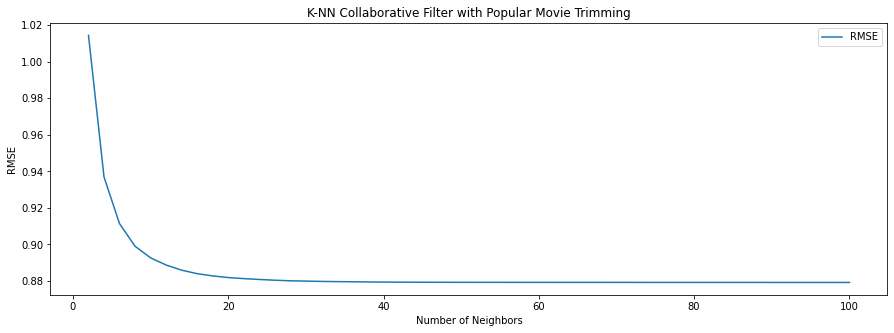

In [43]:
# calculate the difference and filter with threshold to find min k
threshold = 0.001
diff = (np.array(rmse_list_pop[:-1]) - np.array(rmse_list_pop[1:]))
first_idx = np.where(diff < threshold)[0][0]

print('The minimum k is: {}'.format(ks_pop[first_idx]))
print('The corresponding RMSE is: {}\n'.format(rmse_list_pop[first_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_pop, rmse_list_pop, label='RMSE')
plt.title('K-NN Collaborative Filter with Popular Movie Trimming')
plt.xlabel("Number of Neighbors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

#### K-NN collaborative filtering with "unpopular movie trimming"

In [ ]:
rmse_list_unpop, ks_unpop = knn_collab_filter(dataframe=ratings_df, 
                                              trimming='unpopular')

The minimum k is: 2
The corresponding RMSE is: 1.0586420671654124



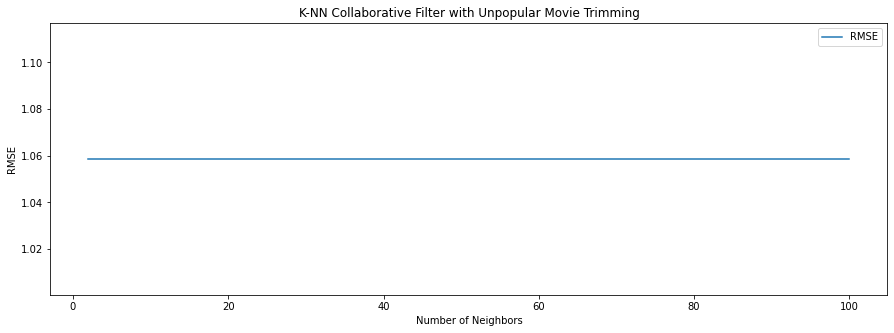

In [ ]:
# calculate the difference and filter with threshold to find min k
threshold = 0.001
diff = (np.array(rmse_list_unpop[:-1]) - np.array(rmse_list_unpop[1:]))
first_idx = np.where(diff < threshold)[0][0]

print('The minimum k is: {}'.format(ks_unpop[first_idx]))
print('The corresponding RMSE is: {}\n'.format(rmse_list_unpop[first_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_unpop, rmse_list_unpop, label='RMSE')
plt.title('K-NN Collaborative Filter with Unpopular Movie Trimming')
plt.xlabel("Number of Neighbors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

#### K-NN collaborative filtering with "high variance movie trimming"

In [44]:
rmse_list_var, ks_var = knn_collab_filter(dataframe=ratings_df, trimming='high_var')

The minimum k is: 2
The corresponding RMSE is: 1.4681868279979575



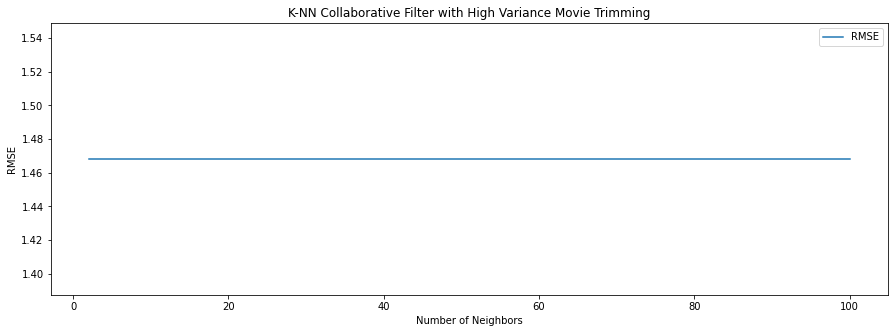

In [45]:
# calculate the difference and filter with threshold to find min k
threshold = 0.001
diff = (np.array(rmse_list_var[:-1]) - np.array(rmse_list_var[1:]))
first_idx = np.where(diff < threshold)[0][0]

print('The minimum k is: {}'.format(ks_var[first_idx]))
print('The corresponding RMSE is: {}\n'.format(rmse_list_var[first_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_var, rmse_list_var, label='RMSE')
plt.title('K-NN Collaborative Filter with High Variance Movie Trimming')
plt.xlabel("Number of Neighbors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

#### Plot ROC Curves

In [46]:
from sklearn import metrics
from surprise import Reader, Dataset, KNNWithMeans, accuracy
from surprise.model_selection import KFold, train_test_split

In [47]:
# parameters
trims = ['popular', 'unpopular', 'high_var', 'no_trim']
thrs = [2.5, 3, 3.5, 4]
min_ks = [18, 2, 2, 18]

# init
results = {'popular': dict(), 
           'unpopular': dict(), 
           'high_var': dict(), 
           'no_trim': dict()}

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]

# start trimming
for i in range(len(trims)):
    # trimming
    if trims[i] == 'popular':
        df_trim = popular_trimming(df=df, threshold=2)
    elif trims[i] == 'unpopular':
        df_trim = unpopular_trimming(df=df, threshold=2)
    elif trims[i] == 'high_var':
        df_trim = high_var_trimming(df=df, var_thr=2, rate_thr=5)
    else:
        df_trim = df

    # ceate data for loop in cross validation
    data = Dataset.load_from_df(df_trim, reader)
    train_set, valid_set = train_test_split(data, test_size=0.1, random_state=42)

    # get the KNN model
    sim= {"name": "pearson_baseline", 
          "user_based": True, 
          "shrinkage": 0}  # 'min_support'
    knn = KNNWithMeans(k=min_ks[i], sim_options=sim, verbose=False)

    # train and test model
    knn.fit(train_set)
    predict = knn.test(valid_set)

    results[trims[i]]['auc'] = list()
    results[trims[i]]['fpr'] = list()
    results[trims[i]]['tpr'] = list()

    # filter the GT based on threshold
    for j in range(len(thrs)):
        # get ground truth and prediction of rating
        y_valid = np.array([i[-1] for i in valid_set])
        y_valid_binary = np.where(y_valid >= thrs[j], 1, 0)
        y_pred = np.array([i.est for i in predict])
        
        # calculate AUC and roc_curve
        auc = metrics.roc_auc_score(y_valid_binary, y_pred)
        fpr, tpr, _ = metrics.roc_curve(y_valid_binary,  y_pred)

        # store value
        results[trims[i]]['auc'].append(auc)
        results[trims[i]]['fpr'].append(fpr)
        results[trims[i]]['tpr'].append(tpr)

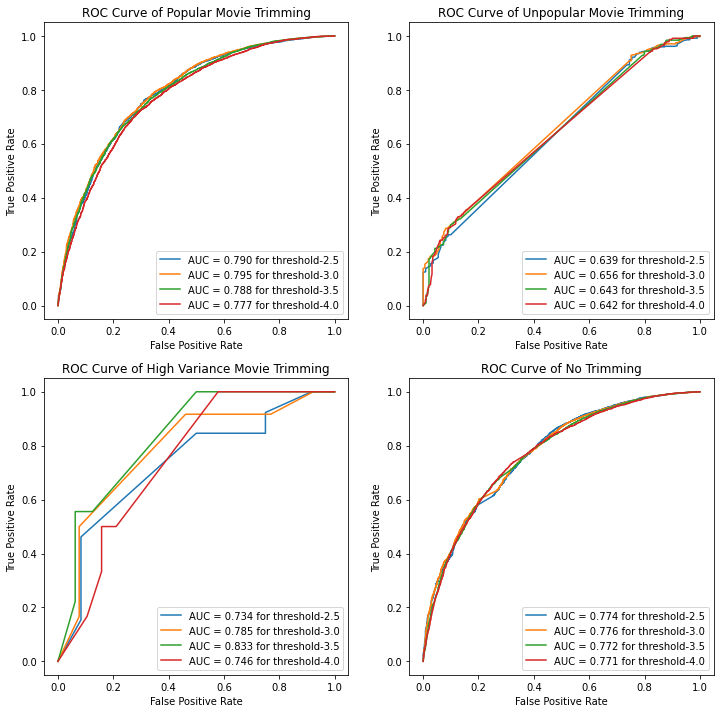

In [48]:
# plot results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i in range(len(thrs)):
    # plot popular movie trimming
    axes[0][0].plot(results['popular']['fpr'][i], results['popular']['tpr'][i], 
                    label=f"AUC = {results['popular']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[0][0].set_xlabel('False Positive Rate')
    axes[0][0].set_ylabel('True Positive Rate')
    axes[0][0].set_title('ROC Curve of Popular Movie Trimming')
    axes[0][0].legend(loc=4)

    # plot unpopular movie trimming
    axes[0][1].plot(results['unpopular']['fpr'][i], results['unpopular']['tpr'][i], 
                    label=f"AUC = {results['unpopular']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[0][1].set_xlabel('False Positive Rate')
    axes[0][1].set_ylabel('True Positive Rate')
    axes[0][1].set_title('ROC Curve of Unpopular Movie Trimming')
    axes[0][1].legend(loc=4)

    # plot high variance movie trimming
    axes[1][0].plot(results['high_var']['fpr'][i], results['high_var']['tpr'][i], 
                    label=f"AUC = {results['high_var']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[1][0].set_xlabel('False Positive Rate')
    axes[1][0].set_ylabel('True Positive Rate')
    axes[1][0].set_title('ROC Curve of High Variance Movie Trimming')
    axes[1][0].legend(loc=4)

    # plot no trimming
    axes[1][1].plot(results['no_trim']['fpr'][i], results['no_trim']['tpr'][i], 
                    label=f"AUC = {results['no_trim']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[1][1].set_xlabel('False Positive Rate')
    axes[1][1].set_ylabel('True Positive Rate')
    axes[1][1].set_title('ROC Curve of No Trimming')
    axes[1][1].legend(loc=4)

plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 6: Within EACH of the 3 trimmed subsets in the dataset, design:</b> 
A k-NN collaborative filter to predict the ratings of the movies (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models’ performance using 10-fold cross validation:
<ul>
  <li>Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.</li>
  <li>Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the training set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 6:</b> The results are shown above.
</div>

## 6 Model-based collaborative filtering

### 6.2 Non-negative matrix factorization (NMF)

<div class="alert alert-block alert-success">
<b>QUESTION 7:</b> Understanding the NMF cost function: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For $U$ fixed, formulate it as a least-squares problem.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 7:</b> No, the cost functions of NMF is not convex. This can be proven by showing that the hessian of the cost function (our objective function) is not positive semidefinite and one can find at least one non-positive eigenvalue of the hessian. For formulation of a least-squares problem, we can consider $\hat{r}_{ij} = \sum_{s=1}^k u_{is}v_{js}$ and thus we get: $$minimize \sum_{i=1}^m \sum_{j=1}^n W_{ij}(r_{ij} - \hat{r}_{ij})^2 $$ , whcih is a least-squares problem.
</div>

#### 6.2.2 Design and test via cross-validation

In [49]:
from sklearn import metrics
from surprise import Reader, Dataset, NMF, accuracy
from surprise.model_selection import KFold, train_test_split

define a function for automation of NMF collaborative filtering with trimming

In [50]:
def nmf_collab_filter(dataframe, trimming):
    '''
    Input:
        dataframe: panda dataframe of original file
        trimming: trimming technique to use - popular, unpopular, high_var, None
    Return:
        rmse_list: list of RMSE for each K of K-NN
        ks: list of all numbers of k for K-NN
    '''
    # init
    rmse_list = []
    mae_list = []
    num_folds = 10
    ks = np.arange(2, 51, 2)

    # read the data
    reader = Reader(rating_scale=(0.5, 5.0))
    df = dataframe[['userId', 'movieId', 'rating']]

    # trimming
    if trimming == 'popular':
        df_trim = popular_trimming(df=df, threshold=2)
    elif trimming == 'unpopular':
        df_trim = unpopular_trimming(df=df, threshold=2)
    elif trimming == 'high_var':
        df_trim = high_var_trimming(df=df, var_thr=2, rate_thr=5)
    else:
        df_trim = df

    # ceate data for loop in cross validation
    data = Dataset.load_from_df(df_trim, reader)

    # start sweeping k
    for k in ks:
        # init
        test_rmse = []
        test_mae = []

        # get the NMF model
        nmf = NMF(n_factors=k)

        # K-fold cross validation
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        
        for trainset, testset in cv.split(data):
            # train and test algorithm.
            nmf.fit(trainset)
            predict = nmf.test(testset)

            # Compute and print Root Mean Squared Error
            test_rmse.append(accuracy.rmse(predict, verbose=False))
            test_mae.append(accuracy.mae(predict, verbose=False))

        # compute the average RMSE
        rmse_list.append(np.array(test_rmse).mean())
        mae_list.append(np.array(test_mae).mean())

    return rmse_list, mae_list, ks

#### Plot the results of the average RMSE (Y-axis) against $k$ (X-axis) and the average MAE (Y-axis) against $k$ (X-axis) of NMF collaborative filter

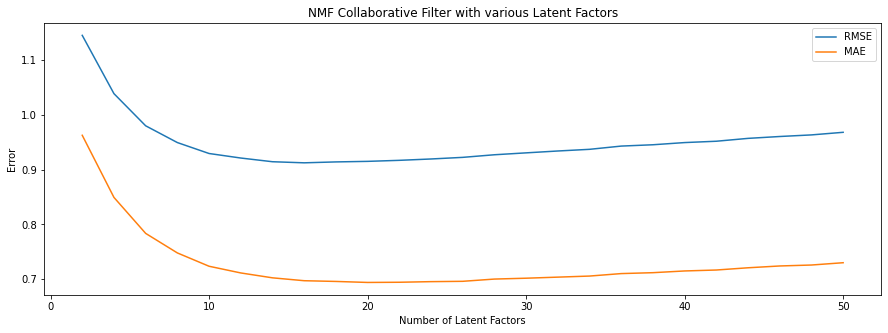

In [51]:
rmse_list, mae_list, ks = nmf_collab_filter(dataframe=ratings_df, trimming=None)

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks, rmse_list, label='RMSE')
plt.plot(ks, mae_list, label='MAE')
plt.title('NMF Collaborative Filter with various Latent Factors')
plt.xlabel("Number of Latent Factors")
plt.ylabel("Error")
plt.legend()
plt.show()

#### Find the optimal number of latent factors

In [52]:
# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list))
opt_k = ks[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}'.format(rmse_list[opt_idx]))
print('The corresponding MAE is: {}'.format(mae_list[opt_idx]))

# check the number of movie genres
movieIDs = np.unique(ratings_df['movieId'].to_numpy())
all_movies = movies_df.loc[movies_df['movieId'].isin(movieIDs)]
all_movies_genres = all_movies['genres'].to_numpy()
all_genres = []
for i in range(all_movies_genres.shape[0]):
    all_genres += all_movies_genres[i].split('|')
all_genres = np.unique(np.array(all_genres))
print('The number of movie genres is: {}'.format(all_genres.shape[0]))

The optimal number of latent factors is: 16
The corresponding RMSE is: 0.9123807696856894
The corresponding MAE is: 0.6969662394767313
The number of movie genres is: 20


#### Performance on trimmed dataset subsets

##### NMF collaborative filtering with "popular movie trimming"

The optimal number of latent factors is: 16
The corresponding RMSE is: 0.8952648672561621



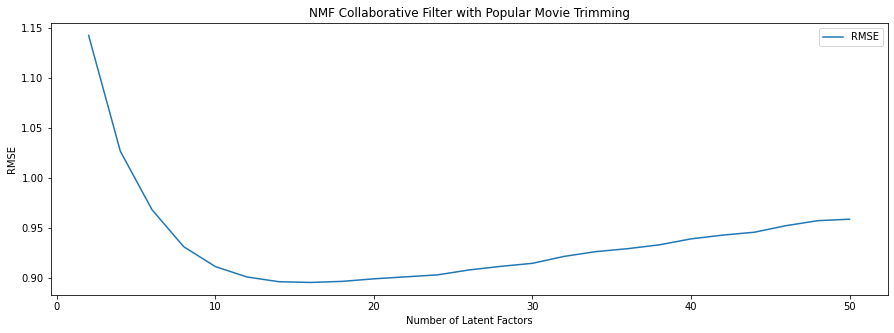

In [ ]:
rmse_list_pop, _ , ks_pop = nmf_collab_filter(dataframe=ratings_df, trimming='popular')

# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list_pop))
opt_k = ks_pop[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}\n'.format(rmse_list_pop[opt_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_pop, rmse_list_pop, label='RMSE')
plt.title('NMF Collaborative Filter with Popular Movie Trimming')
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

##### NMF collaborative filtering with "unpopular movie trimming"

The optimal number of latent factors is: 46
The corresponding RMSE is: 1.132386944037656



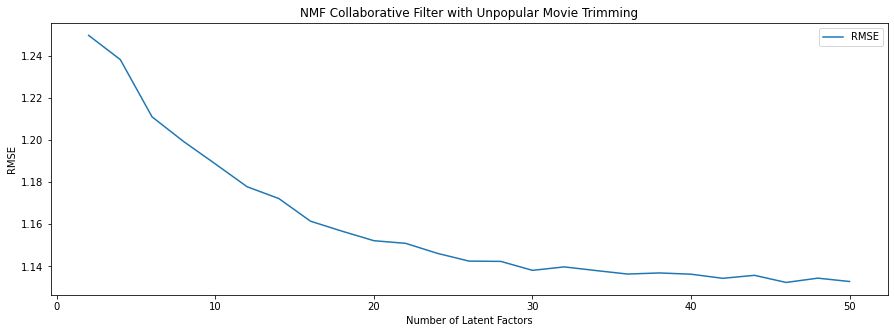

In [ ]:
rmse_list_unpop, _ , ks_unpop = nmf_collab_filter(dataframe=ratings_df, trimming='unpopular')

# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list_unpop))
opt_k = ks_unpop[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}\n'.format(rmse_list_unpop[opt_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_unpop, rmse_list_unpop, label='RMSE')
plt.title('NMF Collaborative Filter with Unpopular Movie Trimming')
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

##### NMF collaborative filtering with "high variance movie trimming"

The optimal number of latent factors is: 50
The corresponding RMSE is: 1.5611404356869338



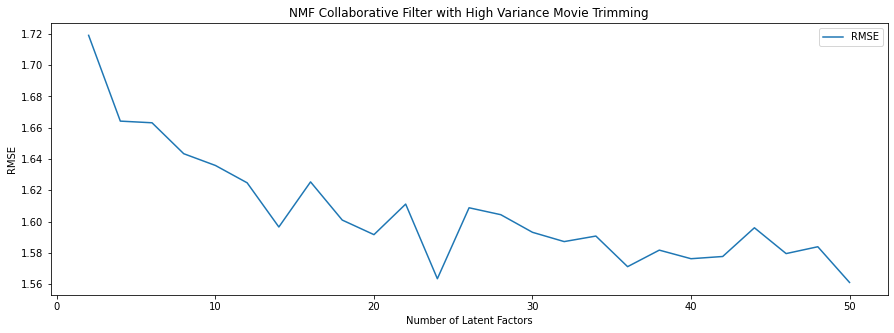

In [53]:
rmse_list_var, _ , ks_var = nmf_collab_filter(dataframe=ratings_df, trimming='high_var')

# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list_var))
opt_k = ks_var[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}\n'.format(rmse_list_var[opt_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_var, rmse_list_var, label='RMSE')
plt.title('NMF Collaborative Filter with High Variance Movie Trimming')
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

##### Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value

In [54]:
# parameters
trims = ['popular', 'unpopular', 'high_var', 'no_trim']
thrs = [2.5, 3, 3.5, 4]

# optimal number of latent factors accoding to previous results
opt_ks = [16, 46, 50, 16]

# init
results = {'popular': dict(), 
           'unpopular': dict(), 
           'high_var': dict(), 
           'no_trim': dict()}

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]

# start trimming
for i in range(len(trims)):
    # trimming
    if trims[i] == 'popular':
        df_trim = popular_trimming(df=df, threshold=2)
    elif trims[i] == 'unpopular':
        df_trim = unpopular_trimming(df=df, threshold=2)
    elif trims[i] == 'high_var':
        df_trim = high_var_trimming(df=df, var_thr=2, rate_thr=5)
    else:
        df_trim = df

    # ceate data for loop in cross validation
    data = Dataset.load_from_df(df_trim, reader)
    train_set, valid_set = train_test_split(data, test_size=0.1, random_state=42)

    # get the NMF model
    nmf = NMF(n_factors=opt_ks[i])

    # train and test model
    nmf.fit(train_set)
    predict = nmf.test(valid_set)

    results[trims[i]]['auc'] = list()
    results[trims[i]]['fpr'] = list()
    results[trims[i]]['tpr'] = list()

    # filter the GT based on threshold
    for j in range(len(thrs)):
        # get ground truth and prediction of rating
        y_valid = np.array([i[-1] for i in valid_set])
        y_valid_binary = np.where(y_valid >= thrs[j], 1, 0)
        y_pred = np.array([i.est for i in predict])
        
        # calculate AUC and roc_curve
        auc = metrics.roc_auc_score(y_valid_binary, y_pred)
        fpr, tpr, _ = metrics.roc_curve(y_valid_binary,  y_pred)

        # store value
        results[trims[i]]['auc'].append(auc)
        results[trims[i]]['fpr'].append(fpr)
        results[trims[i]]['tpr'].append(tpr)

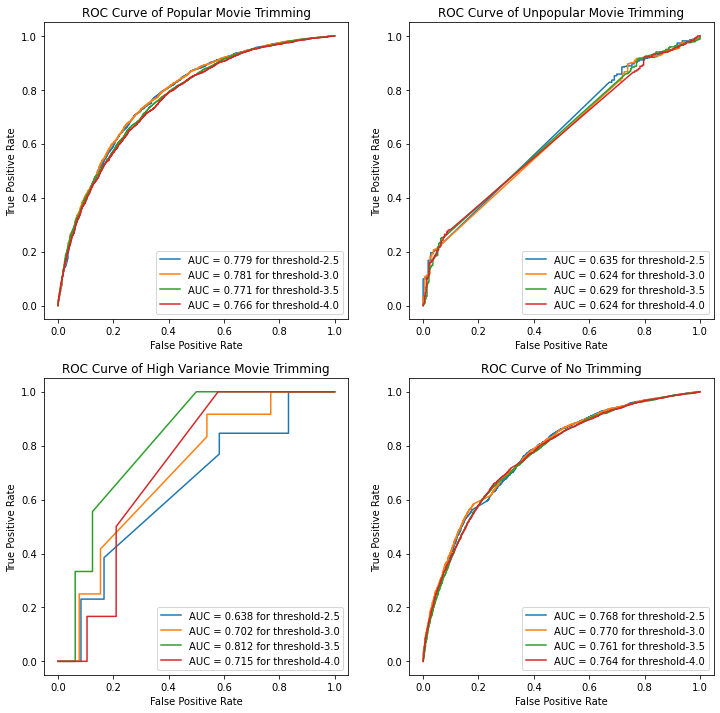

In [55]:
# plot results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i in range(len(thrs)):
    # plot popular movie trimming
    axes[0][0].plot(results['popular']['fpr'][i], results['popular']['tpr'][i], 
                    label=f"AUC = {results['popular']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[0][0].set_xlabel('False Positive Rate')
    axes[0][0].set_ylabel('True Positive Rate')
    axes[0][0].set_title('ROC Curve of Popular Movie Trimming')
    axes[0][0].legend(loc=4)

    # plot unpopular movie trimming
    axes[0][1].plot(results['unpopular']['fpr'][i], results['unpopular']['tpr'][i], 
                    label=f"AUC = {results['unpopular']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[0][1].set_xlabel('False Positive Rate')
    axes[0][1].set_ylabel('True Positive Rate')
    axes[0][1].set_title('ROC Curve of Unpopular Movie Trimming')
    axes[0][1].legend(loc=4)

    # plot high variance movie trimming
    axes[1][0].plot(results['high_var']['fpr'][i], results['high_var']['tpr'][i], 
                    label=f"AUC = {results['high_var']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[1][0].set_xlabel('False Positive Rate')
    axes[1][0].set_ylabel('True Positive Rate')
    axes[1][0].set_title('ROC Curve of High Variance Movie Trimming')
    axes[1][0].legend(loc=4)

    # plot no trimming
    axes[1][1].plot(results['no_trim']['fpr'][i], results['no_trim']['tpr'][i], 
                    label=f"AUC = {results['no_trim']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[1][1].set_xlabel('False Positive Rate')
    axes[1][1].set_ylabel('True Positive Rate')
    axes[1][1].set_title('ROC Curve of No Trimming')
    axes[1][1].legend(loc=4)

plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 8:</b> Designing the NMF Collaborative Filter:
<ul>
  <li><b>A)</b> Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. Sweep $k$ (number of latent factors) from 2 to 50 in step sizes of 2, and for each $k$ compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. Plot the average RMSE (Y-axis) against $k$ (X-axis) and the average MAE (Y-axis) against $k$ (X-axis). For solving this question, use the default value for the regularization parameter.</li>
  <li><b>B)</b> Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?</li>
  <li><b>C)</b> Performance on trimmed dataset subsets</li>
  <li>Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 8:</b>
<ul>
  <li><b>A) </b>The plot of RMSE and MAE of NMF-based collaborative filter are shown above.</li>
  <li><b>B) </b>Based on the result from (A), the optimal number of latent factors is 16 and the corresponding RMSE as well as is around 0.912 and 0.697, respectively. Moreover, based on the calculation, the number of total movie genres is 20. Therefore, the optimal number of latent factors is not equal to the number of genres according to my result here, but it's really close to it. </li>
  <li><b>C) </b>as shown above</li>
  <li>as shown above</li>
</ul>
</div>

#### 6.2.3 Interpretability of NMF

In [ ]:
# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]
# ceate data for loop in cross validation
data = Dataset.load_from_df(df, reader)

# get the NMF model
nmf = NMF(n_factors=20)
# train the model
nmf.fit(data.build_full_trainset())

# get the user factors and item factors
U = nmf.pu
V = nmf.qi

# find the top 10 movies at each latent factor
movieIDs = np.unique(ratings_df['movieId'].to_numpy())
num_genres = V.shape[1]
top_10s = np.array([])
for i in range(num_genres):
    # sort the movies in descending order at current genres
    sorted_idx = np.argsort(V[:, i])[::-1]
    sorted_movieIDs = movieIDs[sorted_idx]
    print(f'Latent factor_{i+1:2d} - Top 10 movie IDs: {sorted_movieIDs[:10]}')
    
    # keep track of all top 10 movie
    top_10s = np.append(top_10s, sorted_movieIDs[:10])

# report the genres of the top 10 movies
top_10s_unique = np.unique(top_10s).astype(int)
top_10_movies = movies_df.loc[movies_df['movieId'].isin(top_10s_unique)]
top_10_movies_genres = top_10_movies['genres'].to_numpy()
top_10_genres = []
for i in range(top_10_movies_genres.shape[0]):
    top_10_genres += top_10_movies_genres[i].split('|')
top_10_genres, _ = np.unique(np.array(top_10_genres), return_counts=True)
print('The number of genres for top 10 movies is: {}'.format(top_10_genres.shape[0]))
print('The genres for top 10 movies is: {}'.format(top_10_genres))

Latent factor_ 1 - Top 10 movie IDs: [  5391   4497   1527 122890   2609   6347   5589   8136 133780    137]
Latent factor_ 2 - Top 10 movie IDs: [  1807 146024   1150   3573  32770   5313   6376  86593  91571  53468]
Latent factor_ 3 - Top 10 movie IDs: [ 4844 73160  4350  3298  8875  6506  1807 26606  4014  4735]
Latent factor_ 4 - Top 10 movie IDs: [ 4708  6997  3744  4735 27563  3614  3858  6506 47518  1095]
Latent factor_ 5 - Top 10 movie IDs: [ 8875  7160 27878  5538  3615  1370 26645  4349  4171  2384]
Latent factor_ 6 - Top 10 movie IDs: [67734 79008  5214  6223 45517  6981  8645  5689  6265 88785]
Latent factor_ 7 - Top 10 movie IDs: [47774  4022  1599 26717  8677  5618  7139  2179  3295  5391]
Latent factor_ 8 - Top 10 movie IDs: [ 1619 84952 45662  3017 27692  2024  2467  6744  4180   310]
Latent factor_ 9 - Top 10 movie IDs: [ 1365  4654  4032  2078  3020 66203  8043  2140 45662  3115]
Latent factor_10 - Top 10 movie IDs: [ 4325  3492  5471  3302  6744  3438  4893 99117  16

<div class="alert alert-block alert-success">
<b>QUESTION 9: </b>Interpreting the NMF model: Perform Non-negative matrix factorization on the ratings matrix $R$ to obtain the factor matrices $U$ and $V$ , where $U$ represents the user-latent factors interaction and $V$ represents the movie-latent factors interaction (use $k = 20$). For each column of $V$ , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 9: </b>The implementation as well as the results are shown above. Based on the results, the top 10 movies do not belong to a particular or a small collection of genre. Moreover, even though we know that a larger value in the latent vector corresponds to higher assciation with a particular movie, the genres of that top 10 movies vary differently. Therefore, it can be concluded that the latent factors and genres don't correlate much, at least not in a one-to-one manner.
</div>

### 6.3 Matrix factorization with bias (MF with bias)

#### 6.3.2 Design and test via cross-validation

In [56]:
from sklearn import metrics
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import KFold, train_test_split

In [58]:
def mf_collab_filter(dataframe, trimming):
    '''
    Input:
        dataframe: panda dataframe of original file
        trimming: trimming technique to use - popular, unpopular, high_var, None
    Return:
        rmse_list: list of RMSE for each K of K-NN
        ks: list of all numbers of k for K-NN
    '''
    # init
    rmse_list = []
    mae_list = []
    num_folds = 10
    ks = np.arange(2, 51, 2)

    # read the data
    reader = Reader(rating_scale=(0.5, 5.0))
    df = dataframe[['userId', 'movieId', 'rating']]

    # trimming
    if trimming == 'popular':
        df_trim = popular_trimming(df=df, threshold=2)
    elif trimming == 'unpopular':
        df_trim = unpopular_trimming(df=df, threshold=2)
    elif trimming == 'high_var':
        df_trim = high_var_trimming(df=df, var_thr=2, rate_thr=5)
    else:
        df_trim = df

    # ceate data for loop in cross validation
    data = Dataset.load_from_df(df_trim, reader)

    # start sweeping k
    for k in ks:
        # init
        test_rmse = []
        test_mae = []

        # get the MF model
        mf = SVD(n_factors=k, biased=True)

        # K-fold cross validation
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        
        for trainset, testset in cv.split(data):
            # train and test algorithm.
            mf.fit(trainset)
            predict = mf.test(testset)

            # Compute and print Root Mean Squared Error
            test_rmse.append(accuracy.rmse(predict, verbose=False))
            test_mae.append(accuracy.mae(predict, verbose=False))

        # compute the average RMSE
        rmse_list.append(np.array(test_rmse).mean())
        mae_list.append(np.array(test_mae).mean())

    return rmse_list, mae_list, ks

#### Plot the results of the average RMSE (Y-axis) against $k$ (X-axis) and the average MAE (Y-axis) against $k$ (X-axis) of MF collaborative filter

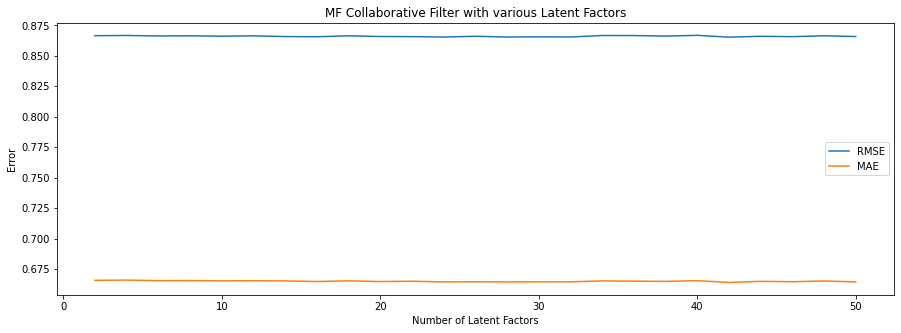

In [59]:
rmse_list, mae_list, ks = mf_collab_filter(dataframe=ratings_df, trimming=None)

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks, rmse_list, label='RMSE')
plt.plot(ks, mae_list, label='MAE')
plt.title('MF Collaborative Filter with various Latent Factors')
plt.xlabel("Number of Latent Factors")
plt.ylabel("Error")
plt.legend()
plt.show()

#### Find the optimal number of latent factors

In [61]:
# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list))
opt_k = ks[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}'.format(rmse_list[opt_idx]))
print('The corresponding MAE is: {}'.format(mae_list[opt_idx]))

# check the number of movie genres
movieIDs = np.unique(ratings_df['movieId'].to_numpy())
all_movies = movies_df.loc[movies_df['movieId'].isin(movieIDs)]
all_movies_genres = all_movies['genres'].to_numpy()
all_genres = []
for i in range(all_movies_genres.shape[0]):
    all_genres += all_movies_genres[i].split('|')
all_genres = np.unique(np.array(all_genres))
print('The number of movie genres is: {}'.format(all_genres.shape[0]))

The optimal number of latent factors is: 42
The corresponding RMSE is: 0.8653435357364703
The corresponding MAE is: 0.66391505591387
The number of movie genres is: 20


#### Performance on trimmed dataset subsets

##### MF collaborative filtering with "popular movie trimming"

The optimal number of latent factors is: 44
The corresponding RMSE is: 0.8561794679730937



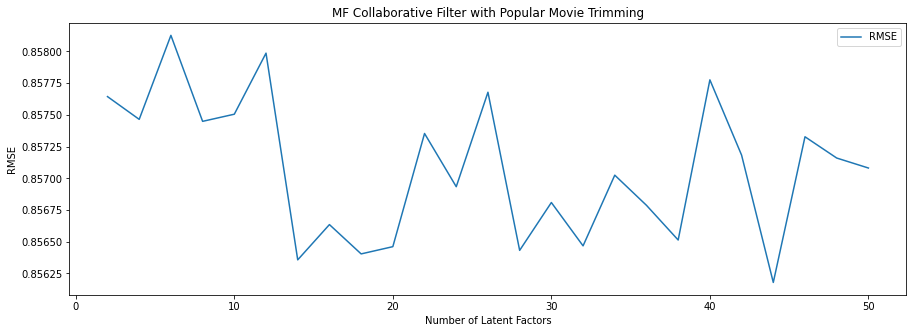

In [ ]:
rmse_list_pop, _ , ks_pop = mf_collab_filter(dataframe=ratings_df, trimming='popular')

# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list_pop))
opt_k = ks_pop[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}\n'.format(rmse_list_pop[opt_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_pop, rmse_list_pop, label='RMSE')
plt.title('MF Collaborative Filter with Popular Movie Trimming')
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

##### MF collaborative filtering with "unpopular movie trimming"

The optimal number of latent factors is: 6
The corresponding RMSE is: 0.8957271049808885



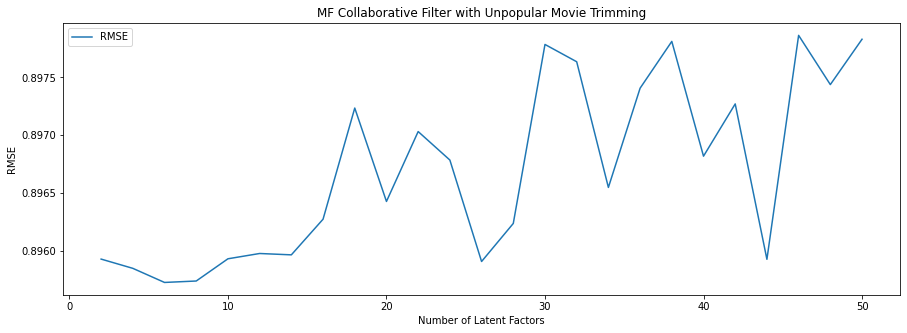

In [62]:
rmse_list_unpop, _ , ks_unpop = mf_collab_filter(dataframe=ratings_df, trimming='unpopular')

# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list_unpop))
opt_k = ks_unpop[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}\n'.format(rmse_list_unpop[opt_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_unpop, rmse_list_unpop, label='RMSE')
plt.title('MF Collaborative Filter with Unpopular Movie Trimming')
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

##### MF collaborative filtering with "high variance movie trimming"

The optimal number of latent factors is: 50
The corresponding RMSE is: 1.5574385233255312



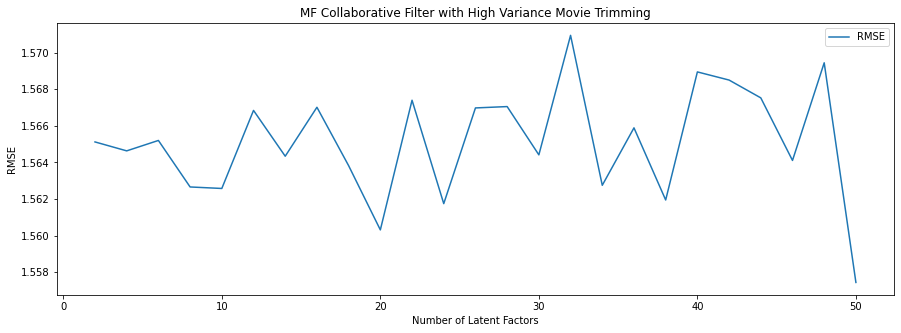

In [63]:
rmse_list_var, _ , ks_var = mf_collab_filter(dataframe=ratings_df, trimming='high_var')

# find the optimal number of latent factors
opt_idx = np.argmin(np.array(rmse_list_var))
opt_k = ks_var[opt_idx]

print('The optimal number of latent factors is: {}'.format(opt_k))
print('The corresponding RMSE is: {}\n'.format(rmse_list_var[opt_idx]))

# plot
plt.figure(figsize=(15, 5))
plt.plot(ks_var, rmse_list_var, label='RMSE')
plt.title('MF Collaborative Filter with High Variance Movie Trimming')
plt.xlabel("Number of Latent Factors")
plt.ylabel("RMSE")
plt.legend()
plt.show()

##### Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value


In [64]:
# parameters
trims = ['popular', 'unpopular', 'high_var', 'no_trim']
thrs = [2.5, 3, 3.5, 4]

# optimal number of latent factors accoding to previous results
opt_ks = [44, 6, 50, 42]

# init
results = {'popular': dict(), 
           'unpopular': dict(), 
           'high_var': dict(), 
           'no_trim': dict()}

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]

# start trimming
for i in range(len(trims)):
    # trimming
    if trims[i] == 'popular':
        df_trim = popular_trimming(df=df, threshold=2)
    elif trims[i] == 'unpopular':
        df_trim = unpopular_trimming(df=df, threshold=2)
    elif trims[i] == 'high_var':
        df_trim = high_var_trimming(df=df, var_thr=2, rate_thr=5)
    else:
        df_trim = df

    # ceate data for loop in cross validation
    data = Dataset.load_from_df(df_trim, reader)
    train_set, valid_set = train_test_split(data, test_size=0.1, random_state=42)

    # get the MF model
    mf = SVD(n_factors=opt_ks[i])

    # train and test model
    mf.fit(train_set)
    predict = mf.test(valid_set)

    results[trims[i]]['auc'] = list()
    results[trims[i]]['fpr'] = list()
    results[trims[i]]['tpr'] = list()

    # filter the GT based on threshold
    for j in range(len(thrs)):
        # get ground truth and prediction of rating
        y_valid = np.array([i[-1] for i in valid_set])
        y_valid_binary = np.where(y_valid >= thrs[j], 1, 0)
        y_pred = np.array([i.est for i in predict])
        
        # calculate AUC and roc_curve
        auc = metrics.roc_auc_score(y_valid_binary, y_pred)
        fpr, tpr, _ = metrics.roc_curve(y_valid_binary,  y_pred)

        # store value
        results[trims[i]]['auc'].append(auc)
        results[trims[i]]['fpr'].append(fpr)
        results[trims[i]]['tpr'].append(tpr)

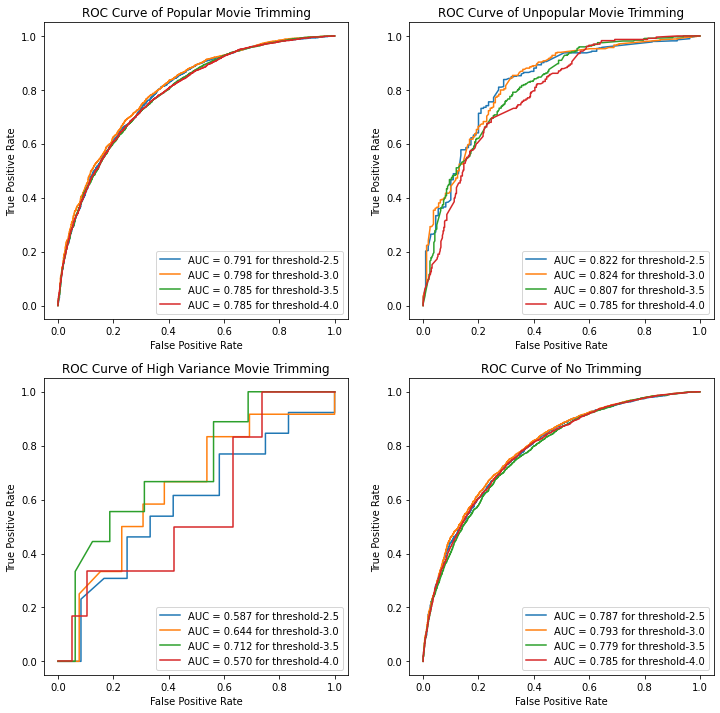

In [65]:
# plot results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i in range(len(thrs)):
    # plot popular movie trimming
    axes[0][0].plot(results['popular']['fpr'][i], results['popular']['tpr'][i], 
                    label=f"AUC = {results['popular']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[0][0].set_xlabel('False Positive Rate')
    axes[0][0].set_ylabel('True Positive Rate')
    axes[0][0].set_title('ROC Curve of Popular Movie Trimming')
    axes[0][0].legend(loc=4)

    # plot unpopular movie trimming
    axes[0][1].plot(results['unpopular']['fpr'][i], results['unpopular']['tpr'][i], 
                    label=f"AUC = {results['unpopular']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[0][1].set_xlabel('False Positive Rate')
    axes[0][1].set_ylabel('True Positive Rate')
    axes[0][1].set_title('ROC Curve of Unpopular Movie Trimming')
    axes[0][1].legend(loc=4)

    # plot high variance movie trimming
    axes[1][0].plot(results['high_var']['fpr'][i], results['high_var']['tpr'][i], 
                    label=f"AUC = {results['high_var']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[1][0].set_xlabel('False Positive Rate')
    axes[1][0].set_ylabel('True Positive Rate')
    axes[1][0].set_title('ROC Curve of High Variance Movie Trimming')
    axes[1][0].legend(loc=4)

    # plot no trimming
    axes[1][1].plot(results['no_trim']['fpr'][i], results['no_trim']['tpr'][i], 
                    label=f"AUC = {results['no_trim']['auc'][i]:.3f} for threshold-{thrs[i]:.1f}")
    axes[1][1].set_xlabel('False Positive Rate')
    axes[1][1].set_ylabel('True Positive Rate')
    axes[1][1].set_title('ROC Curve of No Trimming')
    axes[1][1].legend(loc=4)

plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 10:</b> Designing the MF Collaborative Filter:
<ul>
  <li><b>A)</b> Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep $k$ (number of latent factors) from 2 to 50 in step sizes of 2, and for each $k$ compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against $k$ (X-axis) and the average MAE (Y-axis) against $k$ (X-axis). For solving this question, use the default value for the regularization parameter.</li>
  <li><b>B)</b> Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of $k$ that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?</li>
  <li><b>C)</b> Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets</li>
  <li>Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 10:</b>
<ul>
  <li><b>A) </b>The plot of RMSE and MAE of MF-based collaborative filter are shown above.</li>
  <li><b>B) </b>Based on the result from (A), the optimal number of latent factors is 42 and the corresponding RMSE as well as MAE is around 0.8653 and 0.6639, respectively. Moreover, based on the calculation, the number of total movie genres is 20. Therefore, the optimal number of latent factors is not equal to the number of genres.</li>
  <li><b>C) </b>as shown above</li>
  <li>as shown above</li>
</ul>
</div>

## 7 Naive collaborative filtering

## 7.2 Design and test via cross-validation

In [ ]:
from sklearn import metrics
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold

In [ ]:
def naive_collab_filter(dataframe, trimming):
    '''
    Input:
        dataframe: panda dataframe of original file
        trimming: trimming technique to use - popular, unpopular, high_var, None
    Return:
        rmse: value of RMSE
    '''
    # init
    test_rmse = []

    # parameters
    num_folds = 10

    # read the data
    reader = Reader(rating_scale=(0.5, 5.0))
    df = dataframe[['userId', 'movieId', 'rating']]

    # trimming
    if trimming == 'popular':
        df_trim = popular_trimming(df=df, threshold=2)
    elif trimming == 'unpopular':
        df_trim = unpopular_trimming(df=df, threshold=2)
    elif trimming == 'high_var':
        df_trim = high_var_trimming(df=df, var_thr=2, rate_thr=5)
    else:
        df_trim = df

    # ceate data for loop in cross validation
    data = Dataset.load_from_df(df_trim, reader)

    # K-fold cross validation
    cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        
    for trainset, testset in cv.split(data):
        # get ground truth rating
        y_valid = np.array([i[-1] for i in testset])
        predict = y_valid.mean()

        # Compute and print Root Mean Squared Error
        test_rmse.append(np.sqrt(np.square(y_valid - predict).mean()))

    # average RMSE
    rmse = np.array(test_rmse).mean()

    return rmse

In [ ]:
naive_rmse = naive_collab_filter(dataframe=ratings_df, trimming=None)
print('The average RMSE of Naive Collaborative Filter is: {}'.format(naive_rmse))

The average RMSE of Naive Collaborative Filter is: 1.0424180611077998


In [ ]:
naive_rmse_pop = naive_collab_filter(dataframe=ratings_df, trimming='popular')
print('The average RMSE with popular movie trimming is: {}'.format(naive_rmse_pop))
naive_rmse_unpop = naive_collab_filter(dataframe=ratings_df, trimming='unpopular')
print('The average RMSE with unpopular movie trimming is: {}'.format(naive_rmse_unpop))
naive_rmse_var = naive_collab_filter(dataframe=ratings_df, trimming='high_var')
print('The average RMSE with high variance movie trimming is: {}'.format(naive_rmse_var))

The average RMSE with popular movie trimming is: 1.0353659121738863
The average RMSE with unpopular movie trimming is: 1.1075401704775583
The average RMSE with high variance movie trimming is: 1.561827605686315


<div class="alert alert-block alert-success">
<b>QUESTION 11:</b> Designing a Naive Collaborative Filter:
<ul>
  <li>Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.</li>
  <li>Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 11:</b>
<ul>
  <li>The average RMSE of Naive Collaborative Filter is around 1.042</li>
  <li>The average RMSE of Naive Collaborative Filter with popular movie trimming is around 1.035, with unpopular movie trimming is around 1.1075, and with high variance movie trimming is around 1.562.</li>
</ul>
</div>

## 8 Performance comparison

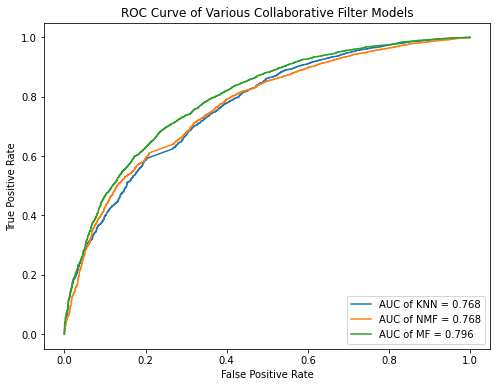

In [ ]:
# parameters
thr = 3
model_names = ['knn', 'nmf', 'mf']

# init
results = {'knn': dict(), 'nmf': dict(), 'mf': dict()}

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]

# ceate data for loop in cross validation
data = Dataset.load_from_df(df, reader)
train_set, valid_set = train_test_split(data, test_size=0.1, random_state=42)

# start
for model_name in model_names:
    # knn model
    if model_name == 'knn':
        sim= {"name": "pearson_baseline", 
              "user_based": True, 
              "shrinkage": 0}  # 'min_support'
        model = KNNWithMeans(k=8, sim_options=sim, verbose=False)

    # NMF model
    elif model_name == 'nmf':
        model = NMF(n_factors=18)

    # MF model
    elif model_name == 'mf':
        model = SVD(n_factors=30, biased=True)

    # train and test model
    model.fit(train_set)
    predict = model.test(valid_set)

    # get ground truth and prediction rating values
    y_valid = np.array([i[-1] for i in valid_set])
    y_valid_binary = np.where(y_valid >= thr, 1, 0)
    y_pred = np.array([i.est for i in predict])

    # calculate AUC and roc_curve
    auc = metrics.roc_auc_score(y_valid_binary, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_valid_binary,  y_pred)
    # store the result
    results[model_name]['auc'] = auc
    results[model_name]['fpr'] = fpr
    results[model_name]['tpr'] = tpr

# plot
plt.figure(figsize=(8, 6))
for model_name in model_names:
    plt.plot(results[model_name]['fpr'], results[model_name]['tpr'],
             label=f"AUC of {model_name.upper()} = {results[model_name]['auc']:.3f}")
plt.title('ROC Curve of Various Collaborative Filter Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 12:</b> Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 12:</b> as shown above
</div>

## 9 Ranking

### 9.2 Evaluating ranking using precision-recall curve

<div class="alert alert-block alert-success">
<b>QUESTION 13:</b> Understanding Precision and Recall in the context of Recommender Systems: Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.
</div>

<div class="alert alert-block alert-success">
<b>ANSWER 13:</b> From equation 12, we know that the precision is equal to the number of intersection between the set $S(t)$ and $G$ over the total number of set $S(t)$. This means that the precision tries to tell us how many proportion / percentage of the predicted recommended movies (items) in set set $S(t)$ is truely correct, which is kind of like the accuracy of the positive prediction. Similarly, the recall is equal to the number of intersection between the set $S(t)$ and $G$ over the total number of set $G$, which means that among all the ground truth positives movies, how many movies has the model successfully recommanded to the user.
</div>

#### Evaluating ranking of k-NN collaborative filter

In [66]:
from surprise import Reader, Dataset, accuracy
from surprise import KNNWithMeans, NMF, SVD
from surprise.model_selection import KFold, cross_validate
from sklearn import metrics

In [67]:
# init
knn_average_precisions = []
knn_average_recalls = []

# parameters
best_k = 18
num_folds = 10
threshold = 3
ts = np.arange(1, 26, 1)

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]
data = Dataset.load_from_df(df, reader)

# get the KNN model
sim= {"name": "pearson_baseline", 
      "user_based": True, 
      "shrinkage": 0}  # 'min_support'
knn = KNNWithMeans(k=best_k , sim_options=sim, verbose=False)

# K-fold cross validation
cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# sweeping t from 1 to 25
for t in ts:

    # init
    fold_precisions = []
    fold_recalls = []

    # start k fold cross validation
    for trainset, testset in cv.split(data):
        # train and test algorithm
        knn.fit(trainset)
        predict = knn.test(testset)

        # init
        user_precisions = []
        user_recalls = []
        user_est_true = {}

        # get [user: (GT, Prediction)] map
        for uid, iid , true_r, est_r, _ in predict:
            if uid not in user_est_true.keys():
                user_est_true[uid] = []
                user_est_true[uid].append((est_r, true_r))
            else:
                user_est_true[uid].append((est_r, true_r))

        # looping through each user
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by predicted value
            user_ratings_sort = sorted(user_ratings, key=lambda x: x[0], reverse=True)
            # get the ground truth set in binary
            set_G = [int(true_r >= threshold) for (est_r, true_r) in user_ratings_sort]
            # get the recommended set of top "t" in binary
            set_S = [int(est_r >= threshold) for (est_r, true_r) in user_ratings_sort[:t]]
            # get the intersection of ground truth and prediction
            set_G_and_S = [int((true_r >= threshold) and (est_r >= threshold)) 
                          for (est_r, true_r) in user_ratings_sort[:t]]
            
            # If some user has rated less than t items, then drop this user
            if len(set_G) < t:
                continue

            # if number of set_G == 0, drop this user
            elif sum(set_G) == 0:
                continue

            # if no recommendation, drop this user
            elif sum(set_S) == 0:
                continue
            
            # else calculate the precision and recall    
            else:
                user_precisions.append(sum(set_G_and_S)/sum(set_S))
                user_recalls.append(sum(set_G_and_S)/sum(set_G))
        
        # store the mean of user precisions and recalls
        fold_precisions.append(np.array(user_precisions).mean())
        fold_recalls.append(np.array(user_recalls).mean())

    # store the mean of fold precisions and recalls
    knn_average_precisions.append(np.array(fold_precisions).mean())
    knn_average_recalls.append(np.array(fold_recalls).mean())

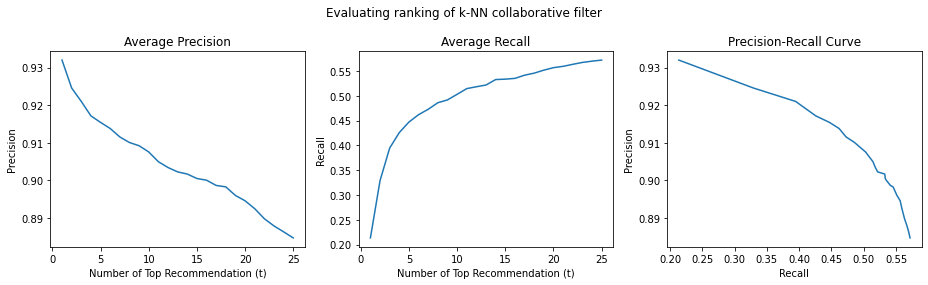

In [68]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))

# Plot average precision (Y-axis) against t (X-axis)
axes[0].plot(ts, knn_average_precisions)
axes[0].set_xlabel('Number of Top Recommendation (t)')
axes[0].set_ylabel('Precision')
axes[0].set_title('Average Precision')

# Plot average precision (Y-axis) against t (X-axis)
axes[1].plot(ts, knn_average_recalls)
axes[1].set_xlabel('Number of Top Recommendation (t)')
axes[1].set_ylabel('Recall')
axes[1].set_title('Average Recall')

# Plot average precision (Y-axis) against t (X-axis)
axes[2].plot(knn_average_recalls, knn_average_precisions)
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')

fig.suptitle('Evaluating ranking of k-NN collaborative filter')
fig.tight_layout()
plt.show()

#### Evaluating ranking of NMF-based collaborative filter

In [71]:
# init
nmf_average_precisions = []
nmf_average_recalls = []

# parameters
best_k = 16
num_folds = 10
threshold = 3
ts = np.arange(1, 26, 1)

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]
data = Dataset.load_from_df(df, reader)

# get the NMF model
nmf = NMF(n_factors=best_k)

# K-fold cross validation
cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# sweeping t from 1 to 25
for t in ts:

    # init
    fold_precisions = []
    fold_recalls = []

    # start k fold cross validation
    for trainset, testset in cv.split(data):
        # train and test algorithm
        nmf.fit(trainset)
        predict = nmf.test(testset)

        # init
        user_precisions = []
        user_recalls = []
        user_est_true = {}

        # get [user: (GT, Prediction)] map
        for uid, iid , true_r, est_r, _ in predict:
            if uid not in user_est_true.keys():
                user_est_true[uid] = []
                user_est_true[uid].append((est_r, true_r))
            else:
                user_est_true[uid].append((est_r, true_r))

        # looping through each user
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by predicted value
            user_ratings_sort = sorted(user_ratings, key=lambda x: x[0], reverse=True)
            # get the ground truth set in binary
            set_G = [int(true_r >= threshold) for (est_r, true_r) in user_ratings_sort]
            # get the recommended set of top "t" in binary
            set_S = [int(est_r >= threshold) for (est_r, true_r) in user_ratings_sort[:t]]
            # get the intersection of ground truth and prediction
            set_G_and_S = [int((true_r >= threshold) and (est_r >= threshold)) 
                          for (est_r, true_r) in user_ratings_sort[:t]]
            
            # If some user has rated less than t items, then drop this user
            if len(set_G) < t:
                continue

            # if number of set_G == 0, drop this user
            elif sum(set_G) == 0:
                continue

            # if no recommendation, drop this user
            elif sum(set_S) == 0:
                continue
            
            # else calculate the precision and recall    
            else:
                user_precisions.append(sum(set_G_and_S)/sum(set_S))
                user_recalls.append(sum(set_G_and_S)/sum(set_G))
        
        # store the mean of user precisions and recalls
        fold_precisions.append(np.array(user_precisions).mean())
        fold_recalls.append(np.array(user_recalls).mean())

    # store the mean of fold precisions and recalls
    nmf_average_precisions.append(np.array(fold_precisions).mean())
    nmf_average_recalls.append(np.array(fold_recalls).mean())

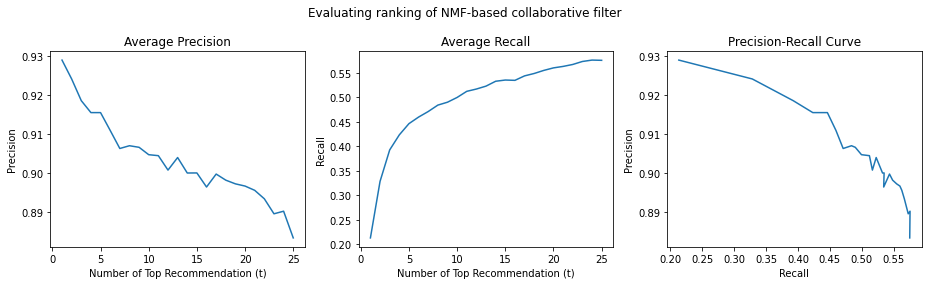

In [72]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))

# Plot average precision (Y-axis) against t (X-axis)
axes[0].plot(ts, nmf_average_precisions)
axes[0].set_xlabel('Number of Top Recommendation (t)')
axes[0].set_ylabel('Precision')
axes[0].set_title('Average Precision')

# Plot average precision (Y-axis) against t (X-axis)
axes[1].plot(ts, nmf_average_recalls)
axes[1].set_xlabel('Number of Top Recommendation (t)')
axes[1].set_ylabel('Recall')
axes[1].set_title('Average Recall')

# Plot average precision (Y-axis) against t (X-axis)
axes[2].plot(nmf_average_recalls, nmf_average_precisions)
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')

fig.suptitle('Evaluating ranking of NMF-based collaborative filter')
fig.tight_layout()
plt.show()

#### Evaluating ranking of MF-based collaborative filter

In [69]:
# init
mf_average_precisions = []
mf_average_recalls = []

# parameters
best_k = 42
num_folds = 10
threshold = 3
ts = np.arange(1, 26, 1)

# read the data
reader = Reader(rating_scale=(0.5, 5.0))
df = ratings_df[['userId', 'movieId', 'rating']]
data = Dataset.load_from_df(df, reader)

# get the MF model with bias
mf = SVD(n_factors=best_k, biased=True)

# K-fold cross validation
cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# sweeping t from 1 to 25
for t in ts:

    # init
    fold_precisions = []
    fold_recalls = []

    # start k fold cross validation
    for trainset, testset in cv.split(data):
        # train and test algorithm
        mf.fit(trainset)
        predict = mf.test(testset)

        # init
        user_precisions = []
        user_recalls = []
        user_est_true = {}

        # get [user: (GT, Prediction)] map
        for uid, iid , true_r, est_r, _ in predict:
            if uid not in user_est_true.keys():
                user_est_true[uid] = []
                user_est_true[uid].append((est_r, true_r))
            else:
                user_est_true[uid].append((est_r, true_r))

        # looping through each user
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by predicted value
            user_ratings_sort = sorted(user_ratings, key=lambda x: x[0], reverse=True)
            # get the ground truth set in binary
            set_G = [int(true_r >= threshold) for (est_r, true_r) in user_ratings_sort]
            # get the recommended set of top "t" in binary
            set_S = [int(est_r >= threshold) for (est_r, true_r) in user_ratings_sort[:t]]
            # get the intersection of ground truth and prediction
            set_G_and_S = [int((true_r >= threshold) and (est_r >= threshold)) 
                          for (est_r, true_r) in user_ratings_sort[:t]]
            
            # If some user has rated less than t items, then drop this user
            if len(set_G) < t:
                continue

            # if number of set_G == 0, drop this user
            elif sum(set_G) == 0:
                continue

            # if no recommendation, drop this user
            elif sum(set_S) == 0:
                continue
            
            # else calculate the precision and recall    
            else:
                user_precisions.append(sum(set_G_and_S)/sum(set_S))
                user_recalls.append(sum(set_G_and_S)/sum(set_G))
        
        # store the mean of user precisions and recalls
        fold_precisions.append(np.array(user_precisions).mean())
        fold_recalls.append(np.array(user_recalls).mean())

    # store the mean of fold precisions and recalls
    mf_average_precisions.append(np.array(fold_precisions).mean())
    mf_average_recalls.append(np.array(fold_recalls).mean())

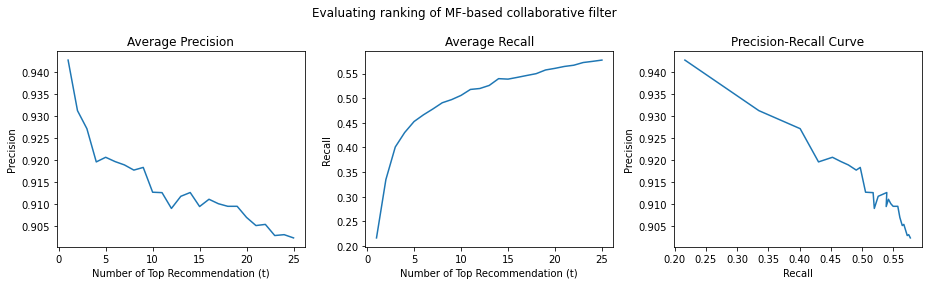

In [70]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))

# Plot average precision (Y-axis) against t (X-axis)
axes[0].plot(ts, mf_average_precisions)
axes[0].set_xlabel('Number of Top Recommendation (t)')
axes[0].set_ylabel('Precision')
axes[0].set_title('Average Precision')

# Plot average precision (Y-axis) against t (X-axis)
axes[1].plot(ts, mf_average_recalls)
axes[1].set_xlabel('Number of Top Recommendation (t)')
axes[1].set_ylabel('Recall')
axes[1].set_title('Average Recall')

# Plot average precision (Y-axis) against t (X-axis)
axes[2].plot(mf_average_recalls, mf_average_precisions)
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')

fig.suptitle('Evaluating ranking of MF-based collaborative filter')
fig.tight_layout()
plt.show()

#### Plot the best precision-recall curves obtained for the three models (k-NN, NMF, MF) in the same figure

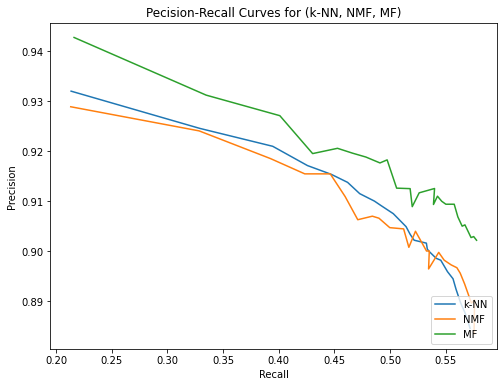

In [73]:
# plot results
plt.figure(figsize=(8, 6))
plt.plot(knn_average_recalls, knn_average_precisions, label='k-NN')
plt.plot(nmf_average_recalls, nmf_average_precisions, label='NMF')
plt.plot(mf_average_recalls, mf_average_precisions, label='MF')
plt.title('Pecision-Recall Curves for (k-NN, NMF, MF)')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc=4)
plt.show()

<div class="alert alert-block alert-success">
<b>QUESTION 14:</b> Comparing the precision-recall metrics for the different models:
<ul>
  <li>For each of the three architectures:</li>
  <ul>
      <li>Plot average precision (Y-axis) against $t$ (X-axis) for the ranking obtained using the model’s predictions.</li>
      <li>Plot the average recall (Y-axis) against $t$ (X-axis) and plot the average precision (Y-axis) against average recall (X-axis).</li>
      <li>Use the best $k$ found in the previous parts and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.</li>
  </ul>
  <li>Plot the best precision-recall curves obtained for the three models (k-NN, NMF, MF) in the same figure. Use this figure to compare the relevance of the recommendation list generated using k-NN, NMF, and MF with bias predictions.</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<b>QUESTION 14:</b> Comparing the precision-recall metrics for the different models:
<ul>
  <li>The plots of all three different models are shown above. One can notice that for each plot in different models, similar curvature can be observed. Average precision plot has a shape of an elbow, average recall plot has a shape of a shoulder, and the precision-recall curve plot has a shape of a mountain going downhill.</li>
  <li>The result is shown above. According to the plot, one can tell that the curves of k-NN and NMF are pretty similar. Therefore, it can be concluded that the recommendation lists generated by these two different models are similar and highly related. As for MF model, it generates a better recommendation list compared to the other two since it's precision-recall curve is slightly shifted toward top right corner, which is the direction of a better model. </li>
</ul>
</div>